# Implementing Sentiment Analysis using GRU

*Sentiment Analysis is the process of determining whether a piece of text is positive, negative, or neutral. It is widely used in social media monitoring, customer feedback and support, identification of derogatory tweets, product analysis, etc. Here we are going to build a Bidirectional RNN network to classify a sentence as either positive or negative using the IMDB Dataset*

In [3]:
# Importing the packages
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import GRU, Dense, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [4]:
# Importing the Dataset
df = pd.read_csv("Data/IMDB Dataset.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Data Preprocessing

In [7]:
#removing the html
def clean_html(text):
    clean =re.compile('<.*?>')
    clean_text = re.sub(clean, '', text)
    return clean_text

In [8]:
# first round of cleaning
def clean_text1(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]'%re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '' , text)
    return text

In [9]:
# second round of cleaning
def clean_text2(text):
    text = re.sub('['',"",,,]', '' ,text)
    text = re.sub('\n', '', text)
    return text

In [10]:
df['review_cleaned'] = pd.DataFrame(df.review.apply(lambda x : clean_html(x)))
df['review_cleaned'] = pd.DataFrame(df.review_cleaned.apply(lambda x : clean_text1(x)))
df['review_cleaned'] = pd.DataFrame(df.review_cleaned.apply(lambda x : clean_text2(x)))

In [11]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trun_type = 'post'

num_epochs = 30

*The text data is first tokenized using the Tokenizer class from Keras.*
- The Tokenizer converts the text data into sequences of integer values, where each integer represents a specific word in the vocabulary

In [12]:
tokenizer = Tokenizer(num_words= vocab_size, split= ' ')
tokenizer.fit_on_texts(df['review_cleaned'].values)

*After tokenization, the text data is then padded to ensure that all sequences have the same length using the pad_sequences function from Keras.*
- This is necessary because the RNN model expects inputs of the same length

In [13]:
X = tokenizer.texts_to_sequences(df['review_cleaned'].values)
X= pad_sequences(X, maxlen= max_length, truncating= trun_type)

In [14]:
Y = pd.get_dummies(df['sentiment'], drop_first= True)

In [15]:
Y = to_categorical(Y, dtype= 'uint8')

In [16]:
Y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

*Once the text data has been tokenized and padded, it is passed to the RNN model, which uses an `Embedding layer` to convert each integer value in the input sequences to a dense vector representation.*
- The `Embedding layer` learns a low-dimensional representation of each word in the vocabulary based on its co-occurrence patterns in the input text data.
- The output of the Embedding layer is then passed to the `GRU layer`, which applies a gru to the sequence of input vectors.
- The `GRU layer` maintains a hidden state that is updated at each time step based on the current input and the previous hidden state.
- The output of the `GRU layer` is a single vector representation of the input sequence, which can be used for classification or other downstream tasks
-Finally, the output of the `GRU layer` is passed to a `Dense layer` with a **softmax activation** function, which outputs a probability distribution over the two possible classes.

In [17]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length= max_length))
model.add(GRU(64))
model.add(Dense(2, activation= 'softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 gru (GRU)                   (None, 64)                15744     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 175874 (687.01 KB)
Trainable params: 175874 (687.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# compile the model
model.compile(optimizer= "adam",
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size= 0.2, stratify= Y, random_state= 317)

In [21]:
X_train.shape, y_train.shape

((40000, 120), (40000, 2))

In [22]:
X_test.shape, y_test.shape

((10000, 120), (10000, 2))

In [23]:
history = model.fit(X_train, y_train,
                    epochs= num_epochs,
                    validation_data = (X_test, y_test),
                    batch_size=128)

Epoch 1/30
313/313 [==============================] - 81s 222ms/step - loss: 0.4861 - accuracy: 0.7413 - val_loss: 0.3619 - val_accuracy: 0.8413
Epoch 2/30
313/313 [==============================] - 62s 198ms/step - loss: 0.3042 - accuracy: 0.8740 - val_loss: 0.3558 - val_accuracy: 0.8475
Epoch 3/30
313/313 [==============================] - 65s 207ms/step - loss: 0.2625 - accuracy: 0.8963 - val_loss: 0.3599 - val_accuracy: 0.8421
Epoch 4/30
313/313 [==============================] - 69s 220ms/step - loss: 0.2344 - accuracy: 0.9097 - val_loss: 0.3876 - val_accuracy: 0.8455
Epoch 5/30
313/313 [==============================] - 56s 180ms/step - loss: 0.2066 - accuracy: 0.9225 - val_loss: 0.3903 - val_accuracy: 0.8388
Epoch 6/30
313/313 [==============================] - 57s 184ms/step - loss: 0.1775 - accuracy: 0.9363 - val_loss: 0.4523 - val_accuracy: 0.8344
Epoch 7/30
313/313 [==============================] - 59s 187ms/step - loss: 0.1522 - accuracy: 0.9469 - val_loss: 0.5082 - val_ac

In [24]:
def plot_graph_stats(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("num_epochs")
    plt.ylabel(string)
    plt.legend([string, 'val'+string])
    plt.show()


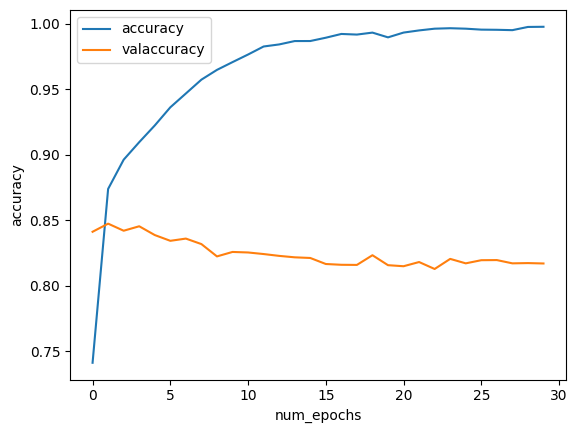

In [25]:
plot_graph_stats(history, 'accuracy')

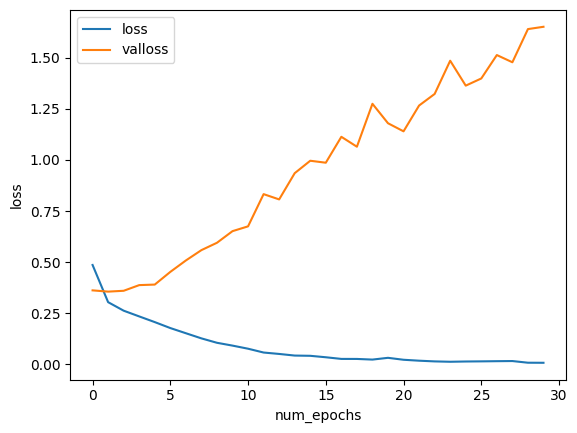

In [26]:
plot_graph_stats(history, 'loss')

*As we can see from the loss graph,that Validation loss is very high then the training loss. This is clear case for Overfitting*

In [27]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length= max_length),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2,activation= 'softmax')
])

In [28]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 gru_1 (GRU)                 (None, 64)                15744     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 175874 (687.01 KB)
Trainable params: 175874 (687.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
model_2.compile(optimizer= 'adam',
                loss= 'categorical_crossentropy',
                metrics= ['accuracy']
                )

In [30]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [31]:
# Train the model
history_2 = model_2.fit(X_train, y_train, validation_data= (X_test, y_test),
                      batch_size= 128, epochs= num_epochs, callbacks=[early_stop])

Epoch 1/30
313/313 [==============================] - 68s 197ms/step - loss: 0.5612 - accuracy: 0.6740 - val_loss: 0.4021 - val_accuracy: 0.8272
Epoch 2/30
313/313 [==============================] - 61s 194ms/step - loss: 0.3243 - accuracy: 0.8661 - val_loss: 0.3605 - val_accuracy: 0.8443
Epoch 3/30
313/313 [==============================] - 56s 178ms/step - loss: 0.2715 - accuracy: 0.8937 - val_loss: 0.3715 - val_accuracy: 0.8396
Epoch 4/30
313/313 [==============================] - 54s 173ms/step - loss: 0.2384 - accuracy: 0.9081 - val_loss: 0.3870 - val_accuracy: 0.8382
Epoch 5/30
313/313 [==============================] - 60s 191ms/step - loss: 0.2138 - accuracy: 0.9193 - val_loss: 0.3940 - val_accuracy: 0.8400
Epoch 6/30
313/313 [==============================] - 65s 209ms/step - loss: 0.1798 - accuracy: 0.9342 - val_loss: 0.4345 - val_accuracy: 0.8349
Epoch 7/30
313/313 [==============================] - 67s 215ms/step - loss: 0.1486 - accuracy: 0.9471 - val_loss: 0.5516 - val_ac

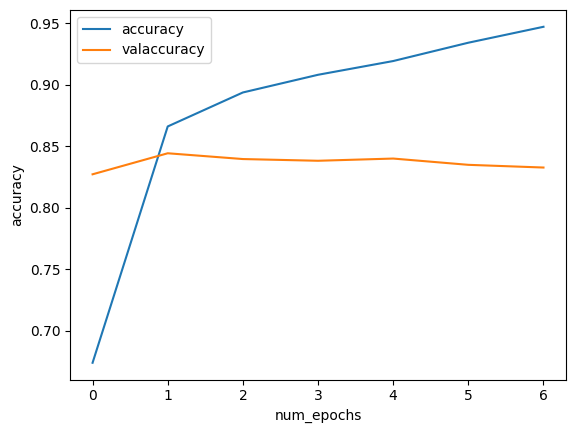

In [32]:
plot_graph_stats(history_2, 'accuracy')

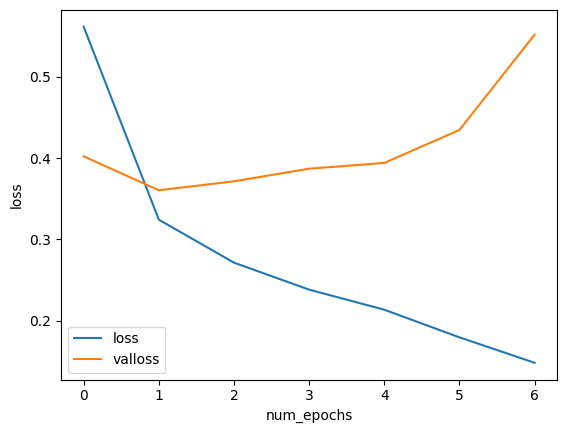

In [33]:
plot_graph_stats(history_2, 'loss')

In [34]:
# Evaluate the model
loss, accuracy = model_2.evaluate(X_test, y_test)

313/313 [==============================] - 8s 26ms/step - loss: 0.3605 - accuracy: 0.8443
